# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

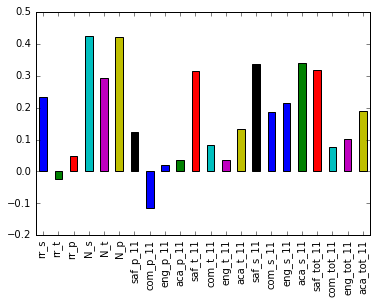

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

#### Observations
 - Strong positive correlatations between SAT score and N_s, N_t, and N_p- indicates- these are parameters that indicate the total number of survery respondents among students, parents, and teachers. The correlation shows that the higher number of respondents/school enrollment, the higher the SAT score.
 - There is also a postive correlation between SAT score and saf_t_11, saf_s_11, and saf_tot_11. This shows a correlation between feeling safe and respected and SAT score. 
 - We also see a positive correlation between aca_s_11, but not between score and other fields related to academic expectations. This shows a strong correlation between score and student's academic expectations, but that parents' and teachers' academic expectations do not hold as much sway.
 - There is a positive correlation between number of student respondents (rr_s) and SAT score- students more involed in surveys may also be more highly involved academically.

### Perceived School Safety and SAT Scores

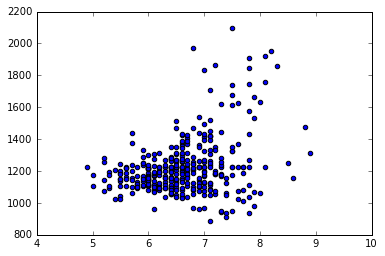

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(combined["saf_s_11"], combined["sat_score"])

 - There appears to be a correlation between percieved safety and SAT score, but not a strong one.

In [13]:
import numpy

safety_scores = combined.groupby("school_dist").agg(numpy.mean)
safety_scores.reset_index(inplace=True)

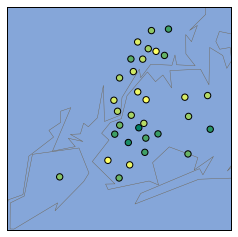

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = safety_scores["lon"].tolist()
latitudes = safety_scores["lat"].tolist()

m.scatter(longitudes, latitudes, s=40, zorder=2, latlon=True,
         c=safety_scores["saf_s_11"], cmap="summer")
plt.show()

 - Manhattan, and parts of Brooklyn and Queens have decent safety scores
 - The Brox has lower safety scores as does parts of Brooklyn

### Race and SAT Score

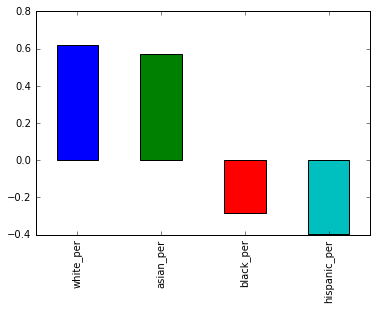

In [15]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

 - It would appear that there is a positive correlation between White and Asian students and a higher SAT score
 - There is a negative correlation between schools with higher percentages of Black or Hispanic students

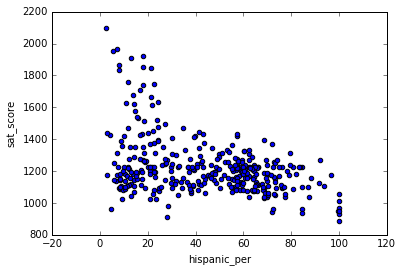

In [16]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

 - While there does seem to be a negative trend, the correlation is not very strong

In [17]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


 - The schools seem to be targeted towards immigrants, international students, and multicultural families. If the students are still learning english and a new school system and culture- this could explain the lower SAT scores.

In [18]:
low_hisp_high_sat = combined[combined["hispanic_per"] < 10]
low_hisp_high_sat = combined[combined["sat_score"] > 1800]
print(low_hisp_high_sat["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


 - These are technical, early college, and highly specialized schools. Many require an entrance exam to get into the school.
 - The high expecations and rigirious acceptance process explains the high scores- these students would be among the most talented in the NYC area.
 - This does not explain the low hispanic rate, perhaps they are not offered the same extent of opportunites as other races in the area. 

### Gender and SAT Score

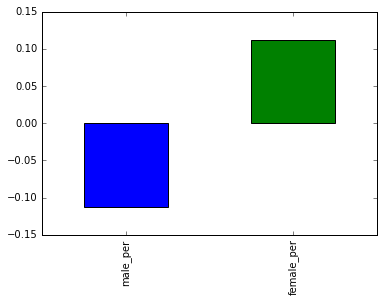

In [19]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

 - There seems to be a positive correlation between higher female percentage and higher SAT score, and a negative correlation between a higher male percentage and a higher SAT score.

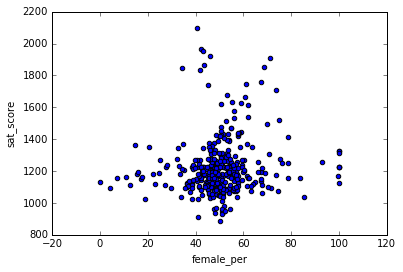

In [20]:
combined.plot.scatter(x="female_per", y="sat_score")

 - Based on the scatter plot, there does not appear to be any correlation between female percentage and SAT score.

In [21]:
high_fem_high_sat = combined[(combined["female_per"] > 60) &
                             (combined["sat_score"] > 1700)]
print(high_fem_high_sat["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


 - These are primarily liberal arts focused schools with high standards

### AP Scores and SAT Scores

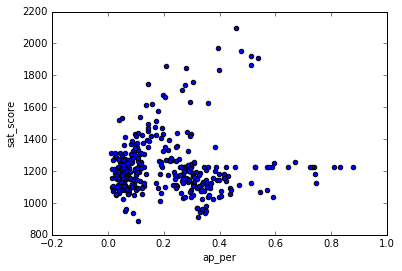

In [22]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

 - There does not appear to be a strong correlation between AP scores and SAT scores

### Class Size and SAT Scores

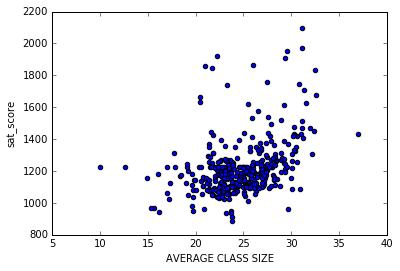

In [23]:
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")

 - There doesn't appear to be any correlation between class size and SAT Scores

### Figuring out which neighborhoods have the best schools

In [24]:
list(combined)

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

In [25]:
cities = combined.city.unique()
print(cities)

['New York' 'Manhattan' 'Bronx' 'Brooklyn' 'Long Island City' 'Elmhurst'
 'Ridgewood' 'Corona' 'Fresh Meadows' 'Flushing' 'Oakland Gardens'
 'Queens Village' 'Bayside' 'Bellerose' 'Far Rockaway' 'Rockaway Park'
 'Ozone Park' 'Jamaica' 'Richmond Hill' 'Forest Hills'
 'Springfield Gardens' 'Saint Albans' 'Hollis' 'Cambria Heights' 'Astoria'
 'Staten Island']


In [45]:
sat_scores_neighborhood = combined.groupby("city").agg(numpy.mean)
sat_scores_neighborhood.reset_index(inplace=True)

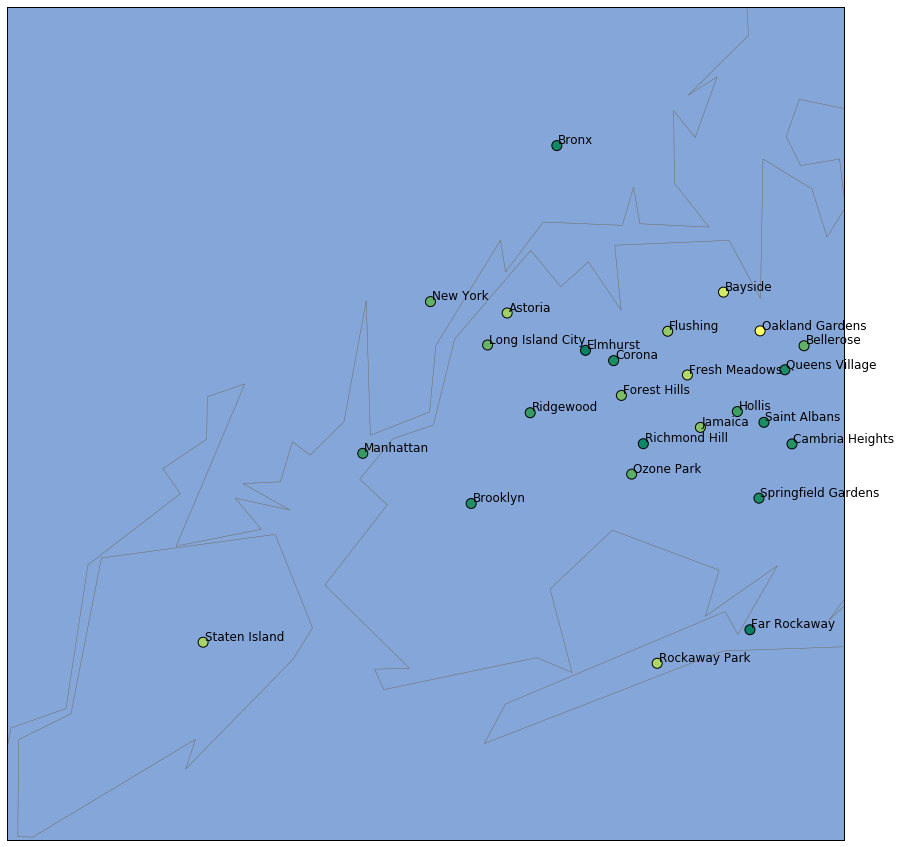

In [47]:
plt.figure(figsize=(15,30))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = sat_scores_neighborhood["lon"].tolist()
latitudes = sat_scores_neighborhood["lat"].tolist()
cities =  sat_scores_neighborhood["city"].tolist()

m.scatter(longitudes, latitudes, s=100, zorder=2, latlon=True,
         c=sat_scores_neighborhood["sat_score"], cmap="summer")

#hard to tell what results mean for each neighborhood without
#accompanying labels
for i in range(len(longitudes)):
    x, y = m(longitudes[i]+0.001, latitudes[i]+0.001)
    plt.text(x, y, cities[i], fontsize=12)

plt.show()

 - The best sat scores seem to come out of Bayside and Oakland Gardens in Queens. Both of these are upper middle class neighborhoods- they likely have much more funding available for their schools than in other areas of New York.
 - Flushing, Fresh Meadows, Astoria, Rockaway Park, and Staten Island also seem to be schools that produce relatively good SAT scores.
 - Manhattan, Brookyln, Richmond Hill, Elmhurst, Springfield Gardens, Far Rockaway, Cambria Heights, Queens Village and Saint Albans seem to produce lower SAT scores. Some of these seem to be more urban/working class areas. A few of these neighborhoods listed, however, are middle class residential areas.
 

#### Next steps:
 - Acquiring a dataset containing property values to find the least expensive neighborhoods that have good schools